**SOW-MKI49: Neural Information Processing Systems**  
*Weeks 4 and 5: Assignment (225 points + 30 bonus points)*  
Author: Umut

In [ ]:
# Group number: ...
# Student 1 name, student 1 number: ...
# Student 2 name, student 2 number: ...
# Student 3 name, student 3 number: ...

https://github.com/basameera/NIPS_week_4_5

In [1]:
from chainer import ChainList, optimizers, serializers
import chainer
import chainer.functions as F
import chainer.links as L
import numpy as np
import cupy

---
# Dataset

![alt text](http://i64.tinypic.com/3rkzq.jpg)

---


**WaveNet component (75 points)**

* Implement missing parts of the call method (y and z). **25 points**
* Implement residual block class. **50 points**

---
Reminder:

* One convolution layer that has 61 kernels of size 2 with no nonlinearities.
![alt text](http://i67.tinypic.com/21mgi2w.png)
![alt text](http://i67.tinypic.com/292n04y.png)
---



# Contributor - Sameera

In [2]:
class _ResidualBlock(ChainList):
    def __init__(self, dilate):
        super(_ResidualBlock, self).__init__(L.DilatedConvolution2D(61, 122, (1, 2), dilate = dilate),
                                             L.Convolution2D(61, 573, 1))

    def __call__(self, x):
        y = F.split_axis(self[0](F.pad(x, ((0, 0), (0, 0), (0, 0), (self[0].dilate[1], 0)), 'constant')), 2, 1)
        y = F.split_axis(self[1](F.sigmoid(y[0]) * F.tanh(y[1])), (61,), 1)

        return x + y[0], y[1]

    
class _WaveNet(ChainList):
    def __init__(self):
        links = (L.Convolution2D(in_channels=61, out_channels=61, ksize=(1, 2)),)
        links += tuple(_ResidualBlock((1, 2 ** (i % 6))) for i in range(6))
        links += (L.Convolution2D(512, 512, 1), L.Convolution2D(512, 3843, 1))
        super(_WaveNet, self).__init__(*links)
        '''
        QUESTIONS
        1. Why/how conv2D_7 has input of 512? If 512, should the last Res. layer has output of 512
        2. Why/How 61*61 and 2*61 comes about?
        '''
        ''' --- Structure --- (in > out)
        0.conv2D (61 -> 61)
        1.Residual (61 > 61, 512)
        2.Residual (61 > 61, 512)
        3.Residual (61 > 61, 512)
        4.Residual (61 > 61, 512)
        5.Residual (61 > 61, 512)
        6.Residual (61 > 61, 512)
        7.conv2D (512 > 512)
        8.conv2D (512 > 3843)
        '''
        
    def __call__(self, x):
        y = self[0](F.pad(x, ((0, 0), (0, 0), (0, 0), (1, 0)), 'constant'))
        z = 0
        # z - skip connection output
        # y - output of each res. layer which becomes the input to next res. layer
        
        for i in range(1, len(self) - 2):#going through Residual layers
            #pass
            y, z_hat = self[i](y)
            z += z_hat
        
        z = F.relu(self[7](z))
        z = self[8](z)
        y, z = F.split_axis(z, [61*61], 1) #if second param is an array, those positions are used as split points

        return F.reshape(y, (y.shape[0], 61, 61, y.shape[3])), F.reshape(z, (z.shape[0], 2, 61, z.shape[3]))
        # check shape sizes

---

Reminder:

![alt text](http://i68.tinypic.com/sy6mix.png)

---

**CRF-RNN component (50 points)**

* Implement missing parts of the call method (z). **25 points**
* Why is z not normalized in the last iteration? **25 points**



# Contributor - Jitendra

### https://en.wikipedia.org/wiki/Conditional_random_field

In [3]:
'''
CRF - Conditional random field
This class calculate Mean-field approximation
'''
class _CRF(ChainList):
    def __init__(self):
        super(_CRF, self).__init__(L.ConvolutionND(1, 2, 2, 1, nobias = True))

    def __call__(self, x, y):
        z = F.softmax(-y)

        for i in range(5):
            z = -y - self[0](F.batch_matmul(z, x))

            if i < 4:
                z = F.softmax(z)

        return z

**WaveCRF model (50 points)**

1. Implement missing parts of the call method (k, psi_u and Q_hat). **20 points**
2. Implement missing parts of the save and load methods (save and load model). **10 points**
3. Implement missing parts of the test and train methods (forward and/or backward propagate). **20 points**

# Contributor - Mohit

In [4]:
class WaveCRF(object):
    def __init__(self):
        self.log = {('test', 'accuracy'): (), ('test', 'loss'): (), ('training', 'accuracy'): (),
                    ('training', 'loss'): ()}
        self.model = ChainList(_WaveNet(), _CRF())
        self.optimizer = optimizers.Adam(0.0002, 0.5)

        self.optimizer.setup(self.model)

    def __call__(self, x):
        k, psi_u = self.model[0](x)
        Q_hat = self.model[1](F.reshape(F.transpose(k, (0, 3, 1, 2)), (-1, 61, 61)),
                              F.reshape(F.transpose(psi_u, (0, 3, 1, 2)), (-1, 2, 61)))

        return F.transpose(F.reshape(Q_hat, (x.shape[0], x.shape[3], 2, 61)), (0, 2, 3, 1))

    @classmethod
    def load(cls, directory):
        self = cls()
        self.log = np.load('{}/log.npy'.format(directory))

        serializers.load_npz('{}/model.npz'.format(directory), self.model)
        serializers.load_npz('{}/optimizer.npz'.format(directory), self.optimizer)

        return self

    def save(self, directory):
        np.save('{}/log.npy'.format(directory), self.log)
        serializers.save_npz('{}/model.npz'.format(directory), self.model)
        serializers.save_npz('{}/optimizer.npz'.format(directory), self.optimizer)

    def test(self, Q, x):
        with chainer.using_config('train', False):
            Q_hat = self(x)
            loss = F.softmax_cross_entropy(Q_hat, Q)

            self.log['test', 'accuracy'] += (float(F.accuracy(Q_hat, Q).data),)
            self.log['test', 'loss'] += (float(loss.data),)

    def train(self, Q, x):
        Q_hat = self(x)
        loss = F.softmax_cross_entropy(Q_hat, Q)

        self.model.cleargrads()
        loss.backward()
        self.optimizer.update()

        self.log['training', 'accuracy'] += (float(F.accuracy(Q_hat, Q).data),)
        self.log['training', 'loss'] += (float(loss.data),)

# Training

In [5]:
%matplotlib inline

import IPython
import chainer
import matplotlib
import numpy
import os
import pickle
import random
import tqdm

In [6]:
batch_size = 30
epochs = 50#100
root = 'WaveNetModel'

In [7]:
with open('Data/piano_rolls.p', 'rb') as f:
    piano_rolls = pickle.load(f, encoding = 'latin1') #works

keys = sorted(piano_rolls.keys())

random.seed(6)
random.shuffle(keys)

test_set = dict((key, piano_rolls[key]) for key in keys[:int(0.1 * len(keys))])
training_set = dict((key, piano_rolls[key]) for key in keys[int(0.1 * len(keys)):])

training_set_keys = list(training_set.keys())
test_set_keys = list(test_set.keys())

print(len(test_set))
print(len(training_set))

363
3273


In [8]:
waveCRF = WaveCRF()

waveCRF.model.to_gpu()
song_id = 2

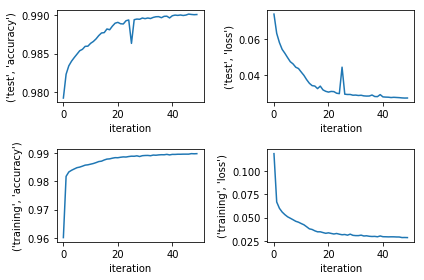


DONE...


In [9]:
for epoch in tqdm.tnrange(epochs, ascii=True, desc="NIPS-G17"):
    random.shuffle(training_set_keys)

    batch = ()

    for key in tqdm.tqdm_notebook(training_set_keys, leave = False):
        i = random.randint(0, training_set[key].shape[1] - 80)
        batch += (training_set[key][32 : 93, i : i + 80],)

        if len(batch) == batch_size:
            batch = waveCRF.model.xp.array(batch)

            waveCRF.train(batch[:, :, 1:].astype('i'), batch[:, :, None, :-1].astype('f'))

            batch = ()

    for key in tqdm.tqdm_notebook(test_set, leave = False):
        batch = waveCRF.model.xp.array((test_set[key][32 : 93],))

        waveCRF.test(batch[:, :, 1:].astype('i'), batch[:, :, None, :-1].astype('f'))

    IPython.display.clear_output()

    for i, key in enumerate(waveCRF.log):
        matplotlib.pyplot.subplot(221 + i)
        matplotlib.pyplot.plot(numpy.array(waveCRF.log[key]).reshape(epoch + 1, -1).mean(1))
        matplotlib.pyplot.xlabel('iteration')
        matplotlib.pyplot.ylabel(key)

    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    os.makedirs('{}/Models/WaveCRF_{}/{}'.format(root, song_id, epoch))
    waveCRF.save('{}/Models/WaveCRF_{}/{}'.format(root, song_id, epoch))

print("DONE...")

**Test (50 points)**  

* Generate a number of samples, pick the best one and play it in the notebook. **50 points**

In [7]:
# Test

model_dir = 'WaveNetModel/Models/WaveCRF_1/2'
model_dir = '2/Models/WaveCRF_WaveNetModel/49'

waveCRF_test = WaveCRF()
waveCRF_test.load(model_dir)
waveCRF_test.model.to_gpu()

In [8]:
batch = ()
cnt = 0
out_sample = 0
for key in tqdm.tqdm_notebook(test_set_keys, leave = False):
    i = random.randint(0, test_set[key].shape[1] - 80)
    Tsample = test_set[key][32 : 93, i : i + 80]
    batch += (Tsample,)
    #print(Tsample.shape)
    cnt += 1
    if cnt>0:
        out_sample = Tsample
        break
        
print("---")
print(batch)
batch = waveCRF.model.xp.array(batch)
print(batch[0].shape)
#print(batch[:, :, 1:])
Qt = batch[:, :, 1:].astype('i')
Xt = batch[:, :, None, :-1].astype('f')
print(Qt.shape)
print(Xt.shape)
#Xt = F.pad(Xt, ((0, 0), (0, 0), (0, 0), (1, 0)), 'constant')
print(Xt.shape)

---
(array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]),)
(61, 80)
(1, 61, 79)
(1, 61, 1, 79)
(1, 61, 1, 79)


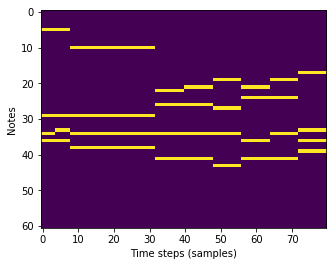

In [10]:
import matplotlib.pyplot as plt
test_song = batch[0]
input_song = cupy.asnumpy(batch[0])
plt.imshow(input_song)
plt.xlabel('Time steps (samples)')
plt.ylabel("Notes")

song_id = 2
np.savez('input_song_{}.npz'.format(song_id), input_song=input_song)

In [11]:
print(Xt.shape)
prediction = waveCRF(Xt)

(1, 61, 1, 79)


(1, 2, 61, 79)
[[ 0.10343507  0.26162124  0.20742315 ... -0.2689603  -0.3929732
  -0.4873372 ]
 [ 0.02139567  0.10310006 -0.26150882 ...  0.64871836  0.3706168
   0.4111697 ]
 [-0.19519275 -0.62104475 -0.67714345 ...  0.29078868  0.37264413
   0.29118037]
 ...
 [ 0.09840181  0.57288235  0.2368488  ...  0.41402966  0.25316355
   0.3406285 ]
 [-0.07045954 -0.46164453 -0.19831586 ...  0.27861217  0.34320286
   0.37154096]
 [-0.29783198 -0.40987128 -0.40781662 ... -0.18628332 -0.08692026
  -0.24545729]]


Text(0, 0.5, 'Notes')

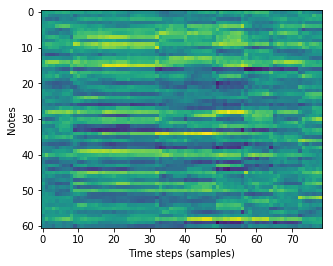

In [12]:
print(prediction.shape)
print(prediction[0].data[0])

plt.imshow(cupy.asnumpy(prediction[0].data[0]))
plt.xlabel('Time steps (samples)')
plt.ylabel("Notes")

Text(0, 0.5, 'Notes')

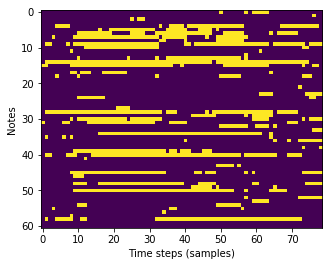

In [15]:
out_song = cupy.asnumpy(prediction[0].data[0])>0.5
plt.imshow(out_song)
plt.xlabel('Time steps (samples)')
plt.ylabel("Notes")

In [16]:
np.savez('output_song_{}.npz'.format(song_id), out_song=out_song)

In [17]:
new_song = np.load('new_song.npz')
new_song = new_song[new_song.files[0]]

print(new_song)

[[False  True  True ... False False False]
 [False  True False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [False False False ... False False False]
 [False False False ... False False False]]


**Bonus question (30 points)**

* Discuss how you can improve the model (you can talk about different architectures or different ways to encode the inputs, etc.) **10 points**
* Discuss the assumptions behind the meanfield approximation and its shortcomings. **10 points**
* Prove that the iterative update equation (CRF-RNN component) is differentiable so that we can backpropagate through them. **10 points**